In [1]:
import pandas as pd

In [3]:
import seaborn as sns

In [5]:
import numpy as np

In [216]:
fpath = 'data/prep/'
dfile = 'form_data_v2.0.csv'

In [218]:
df = pd.read_csv( fpath + dfile, header=0, parse_dates=True )

In [222]:
# flat races
df = df[df.Type.isna()]

In [226]:
# remove entries with missing Draw - some of these could be imputed or manually entered
# print(df.RaceId[df.Draw.isna()].unique())
df = df[~df.Draw.isna()]

In [230]:
# no. declared, ie FieldSize + RR + withdrawn
DeclFieldSize = df[['RaceId', 'Draw']].groupby('RaceId').max().squeeze().rename('DeclFieldSize').astype(int)

In [240]:
df = df.join(DeclFieldSize, on='RaceId')

In [242]:
# replace non-numeric Posn with last place and cast to int TODO
# df[~df.Posn.str.isnumeric(), 'Posn'] = df[~df.Posn.str.isnumeric(), 'DeclFieldSize']
df['Posn'] = df.apply(lambda r: int(r.Posn) if r.Posn.isnumeric() else r.DeclFieldSize, axis=1)

In [276]:
new = df[df.CourseName=='Newmarket']
# new

In [246]:
yor = df[df.CourseName=='York']
# yor

In [278]:
dat = new

In [280]:
# def

In [282]:
dat = pd.DataFrame({'FieldSize': dat.DeclFieldSize, 
                    'Draw': dat.Draw.apply(int), 
                    'Index': dat.ReturnPlace+dat.ReturnWin})

In [284]:
g = dat[['FieldSize','Draw','Index']].groupby(['FieldSize','Draw'])
dat_ave = g.mean()
dat_ave_n = g.count()

In [286]:
dat_ave = dat_ave.reset_index().pivot_table(index='FieldSize',columns='Draw') # NAs are automatically masked in heatmap
dat_ave_n = dat_ave_n.reset_index().pivot_table(index='FieldSize',columns='Draw').fillna(0)

In [288]:
dat_ave_np = dat_ave.to_numpy()
dat_ave_n_np = dat_ave_n.to_numpy()

In [290]:
# log-scale support (n) for annot
dat_ave_n_np = np.round(np.log(dat_ave_n_np+1))

In [292]:
n_draw = dat_ave_np.shape[1]

In [294]:
i2 = (dat_ave_n_np!=0).sum(axis=1)
i1 = (n_draw - i2)//2

In [296]:
hm_data = np.zeros(dat_ave_np.shape)
hm_annot = np.empty(dat_ave_n_np.shape, dtype=str)

In [298]:
for i in range(hm_data.shape[0]):
    hm_data[ i, i1[i]:(i1[i]+i2[i]) ] = dat_ave_np[ i, :i2[i]] 
    hm_annot[ i, i1[i]:(i1[i]+i2[i]) ] = dat_ave_n_np[ i, :i2[i]] 

In [300]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.figure()
plt.title('E/W Return Draw Bias, <York> (all races)')

Text(0.5, 1.0, 'E/W Return Draw Bias, <York> (all races)')

In [302]:
sns.heatmap(pd.DataFrame(hm_data, index=dat_ave.index, columns=dat_ave.columns.get_level_values(1).rename('Draw (low to high, centered)')),
            cmap='gist_earth_r', robust=True, annot=hm_annot, fmt='', annot_kws={'fontsize': 'xx-small'},
            xticklabels=False, yticklabels=2)
plt.savefig('image.png')

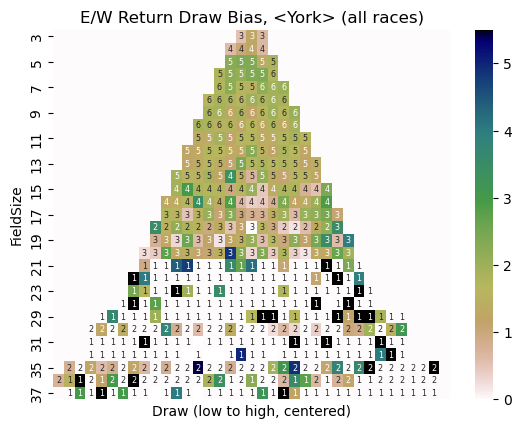

In [303]:
plt.show()